In [1]:
import pandas as pd
import numpy as np

from axisfuzzy.analysis.accessor import FuzzyAccessor
from axisfuzzy.analysis.app.model import Model
from axisfuzzy.analysis.component.basic import (
    ToolNormalization,
    ToolWeightNormalization,
    ToolFuzzification,
    ToolSimpleAggregation
)
from axisfuzzy.analysis.build_in import ContractCrispTable, ContractWeightVector
from axisfuzzy.fuzzifier import Fuzzifier # 假设 Fuzzifier 在这里

In [2]:
# --- 1. 准备一个模糊化引擎 ---
# (假设 Fuzzifier 和 TriangularMF 已经可以正常工作)
my_fuzzifier = Fuzzifier(
    mf='gaussmf',
    mtype='qrofn',  # 假设目标是 q-rung orthopair fuzzy number
    pi = 0.2,
    mf_params=[{'sigma': 0.15, 'c': 0.5}]
)

In [3]:
# --- 2. 定义一个复杂模型 ---
class ComplexAnalysisModel(Model):
    """
    一个多输入、多输出的演示模型。
    - 输入: raw_data (DataFrame), raw_weights (vector)
    - 流程:
      1. 数据和权重分别进行归一化。
      2. 归一化后的数据进行模糊化。
      3. 对模糊化后的数据按行进行聚合（例如求均值）。
    - 输出: 聚合后的分数 (scores), 模糊化后的数据 (fuzzy_table)
    """

    def __init__(self):
        super().__init__()
        # 在 __init__ 中定义所有需要的“层”/组件
        self.data_normalizer = ToolNormalization(method='min_max', axis=0)
        self.weight_normalizer = ToolWeightNormalization()
        # 注意：ToolFuzzification 需要一个 Fuzzifier 实例
        # 这里我们假设一个简单的 Fuzzifier
        self.fuzzifier = ToolFuzzification(fuzzifier=my_fuzzifier)
        self.aggregator = ToolSimpleAggregation(operation='mean', axis=1)

    def get_config(self) -> dict:
        return {}

    def forward(self, data: ContractCrispTable, weights: ContractWeightVector):
        """
        用非常直观的方式定义数据流。
        这里的所有调用都将被自动翻译成 pipeline.add()。
        """
        # 分支 1: 处理数据
        norm_data = self.data_normalizer(data)
        fuzzy_table = self.fuzzifier(norm_data)

        # 分支 2: 处理权重 (在这个例子中，我们没有在下游使用它，但展示了分支能力)
        norm_weights = self.weight_normalizer(weights)

        # 聚合操作
        # scores = self.aggregator(fuzzy_table)

        # 返回一个包含多个输出的字典
        # return {'scores': scores, 'fuzzy_table': fuzzy_table}
        return {'fuzzy_table': fuzzy_table}

In [4]:
# --- 3. 准备输入数据 ---
df = pd.DataFrame(np.random.rand(5, 3), columns=['Attr1', 'Attr2', 'Attr3'])
w = np.array([0.5, 0.3, 0.2])

In [5]:
print("--- Initial Data ---")
print("DataFrame:\n", df)
print("Weights:\n", w)
print("-" * 20 + "\n")

--- Initial Data ---
DataFrame:
       Attr1     Attr2     Attr3
0  0.404620  0.451911  0.475134
1  0.607949  0.674997  0.380447
2  0.076894  0.202944  0.590770
3  0.986766  0.325584  0.291906
4  0.468394  0.140246  0.620863
Weights:
 [0.5 0.3 0.2]
--------------------



In [6]:
model = ComplexAnalysisModel()
model.build()

--- Building FuzzyPipeline for 'ComplexAnalysisModel'... ---
--- Starting symbolic trace of 'forward' method... ---
  > Tracing call to 'ToolNormalization'...
  > Tracing call to 'ToolFuzzification'...
  > Tracing call to 'ToolWeightNormalization'...
--- Symbolic trace complete. ---
--- FuzzyPipeline for 'ComplexAnalysisModel' built successfully. ---



In [7]:
t = model.step_by_step(df, w)

In [8]:
t.result

In [9]:
next(t)

{'step_id': 'ToolNormalization_run_161f266d',
 'step_name': 'ToolNormalization.run',
 'step_index': 1,
 'total_steps': 3,
 'result':       Attr1     Attr2     Attr3
 0  0.360190  0.582824  0.556998
 1  0.583660  1.000000  0.269156
 2  0.000000  0.117248  0.908521
 3  1.000000  0.346588  0.000000
 4  0.430281  0.000000  1.000000,
 'execution_time(ms)': 3.12196}

In [10]:
t.result

,Attr1,Attr2,Attr3
0,0.360190,0.582824,0.556998
1,0.583660,1.000000,0.269156
2,0.000000,0.117248,0.908521
3,1.000000,0.346588,0.000000
4,0.430281,0.000000,1.000000


In [11]:
next(t)

{'step_id': 'ToolWeightNormalization_run_6d6ae507',
 'step_name': 'ToolWeightNormalization.run',
 'step_index': 2,
 'total_steps': 3,
 'result': array([0.5, 0.3, 0.2]),
 'execution_time(ms)': 0.09621}

In [13]:
t.result

array([0.5, 0.3, 0.2])

In [14]:
next(t)

{'step_id': 'ToolFuzzification_run_9b2454b1',
 'step_name': 'ToolFuzzification.run',
 'step_index': 3,
 'total_steps': 3,
 'result':              Attr1            Attr2            Attr3
 0  <0.6477,0.1523>       <0.8586,0>       <0.9303,0>
 1        <0.856,0>  <0.0039,0.7961>    <0.306,0.494>
 2  <0.0039,0.7961>  <0.0386,0.7614>  <0.0245,0.7755>
 3  <0.0039,0.7961>  <0.5927,0.2073>  <0.0039,0.7961>
 4       <0.8976,0>  <0.0039,0.7961>  <0.0039,0.7961>,
 'execution_time(ms)': 0.49717}

In [15]:
t.result

             Attr1            Attr2            Attr3
0  <0.6477,0.1523>       <0.8586,0>       <0.9303,0>
1        <0.856,0>  <0.0039,0.7961>    <0.306,0.494>
2  <0.0039,0.7961>  <0.0386,0.7614>  <0.0245,0.7755>
3  <0.0039,0.7961>  <0.5927,0.2073>  <0.0039,0.7961>
4       <0.8976,0>  <0.0039,0.7961>  <0.0039,0.7961>

In [16]:
df.fuzzy.run(model, weights=w, return_intermediate=True)

({'ToolWeightNormalization.run': array([0.5, 0.3, 0.2]),
  'ToolFuzzification.run':              Attr1            Attr2            Attr3
  0  <0.6477,0.1523>       <0.8586,0>       <0.9303,0>
  1        <0.856,0>  <0.0039,0.7961>    <0.306,0.494>
  2  <0.0039,0.7961>  <0.0386,0.7614>  <0.0245,0.7755>
  3  <0.0039,0.7961>  <0.5927,0.2073>  <0.0039,0.7961>
  4       <0.8976,0>  <0.0039,0.7961>  <0.0039,0.7961>},
 {'input_weights_c53bf417': array([0.5, 0.3, 0.2]),
  'input_data_47c79542':       Attr1     Attr2     Attr3
  0  0.404620  0.451911  0.475134
  1  0.607949  0.674997  0.380447
  2  0.076894  0.202944  0.590770
  3  0.986766  0.325584  0.291906
  4  0.468394  0.140246  0.620863,
  'ToolNormalization_run_161f266d':       Attr1     Attr2     Attr3
  0  0.360190  0.582824  0.556998
  1  0.583660  1.000000  0.269156
  2  0.000000  0.117248  0.908521
  3  1.000000  0.346588  0.000000
  4  0.430281  0.000000  1.000000,
  'ToolWeightNormalization_run_6d6ae507': array([0.5, 0.3, 0.2]),
 

In [17]:
# --- 4. 实例化模型 ---
model = ComplexAnalysisModel()
model.build()
model.run(data=df, weights=w)

--- Building FuzzyPipeline for 'ComplexAnalysisModel'... ---
--- Starting symbolic trace of 'forward' method... ---
  > Tracing call to 'ToolNormalization'...
  > Tracing call to 'ToolFuzzification'...
  > Tracing call to 'ToolWeightNormalization'...
--- Symbolic trace complete. ---
--- FuzzyPipeline for 'ComplexAnalysisModel' built successfully. ---



{'ToolFuzzification.run':              Attr1            Attr2            Attr3
 0  <0.6477,0.1523>       <0.8586,0>       <0.9303,0>
 1        <0.856,0>  <0.0039,0.7961>    <0.306,0.494>
 2  <0.0039,0.7961>  <0.0386,0.7614>  <0.0245,0.7755>
 3  <0.0039,0.7961>  <0.5927,0.2073>  <0.0039,0.7961>
 4       <0.8976,0>  <0.0039,0.7961>  <0.0039,0.7961>,
 'ToolWeightNormalization.run': array([0.5, 0.3, 0.2])}

In [18]:
model.summary()

Model: "ComplexAnalysisModel"
Layer (type)                     Input Contracts               Output Contracts         
----------------------------------------------------------------------------------------
Input: data                      -                             ContractCrispTable       
Input: weights                   -                             ContractWeightVector     
ToolNormalization                ContractCrispTable            ContractCrispTable       
ToolWeightNormalization          ContractWeightVector          ContractNormalizedWeights
ToolFuzzification                ContractCrispTable            ContractFuzzyTable       
----------------------------------------------------------------------------------------
Total layers: 3


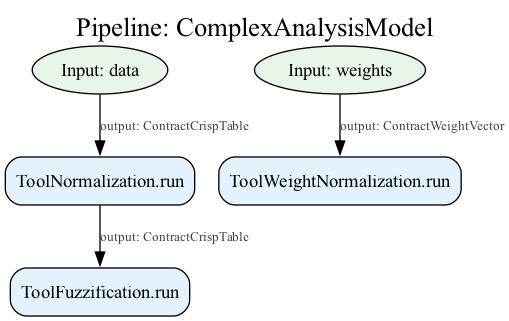

In [19]:
model.visualize()

In [20]:
model.save('complex_model_demo.json')

Model 'ComplexAnalysisModel' configuration saved to: complex_model_demo.json


In [21]:
x = Model.load('complex_model_demo.json')

Model loaded from: complex_model_demo.json. Please call .build() before use.


In [22]:
x.build()

--- Building FuzzyPipeline for 'ComplexAnalysisModel'... ---
--- Starting symbolic trace of 'forward' method... ---
  > Tracing call to 'ToolNormalization'...
  > Tracing call to 'ToolFuzzification'...
  > Tracing call to 'ToolWeightNormalization'...
--- Symbolic trace complete. ---
--- FuzzyPipeline for 'ComplexAnalysisModel' built successfully. ---



In [23]:
x.summary()

Model: "ComplexAnalysisModel"
Layer (type)                     Input Contracts               Output Contracts         
----------------------------------------------------------------------------------------
Input: data                      -                             ContractCrispTable       
Input: weights                   -                             ContractWeightVector     
ToolNormalization                ContractCrispTable            ContractCrispTable       
ToolWeightNormalization          ContractWeightVector          ContractNormalizedWeights
ToolFuzzification                ContractCrispTable            ContractFuzzyTable       
----------------------------------------------------------------------------------------
Total layers: 3


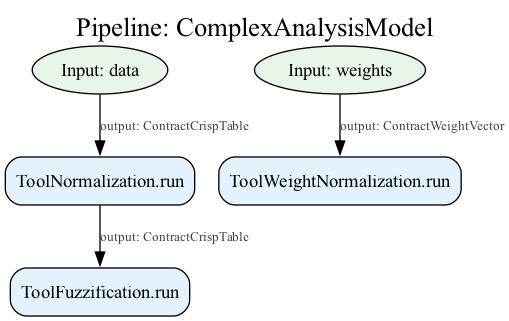

In [24]:
x.visualize()